<h1><center>Home Credit Risk Prediction</center></h1>
<center> - sections 7/8 - </center>
<center>December 2024</center>
<center>Celine Ng</center>

# Table of Contents

1. Project Introduction
    1. Notebook Preparation
    1. Data loading
1. Main Data Preparation
    1. Data cleaning
    1. Dataframes and keys
    1. Train Test Split
    1. Quick EDA
        1. Keys present in each table
        1. Distribution
    1. Aggregation
1. Initial Data Cleaning
    1. Datatypes
    1. Missing values
1. EDA
    1. Original Application Table Distribution
    1. Correlation
    1. Statistical Inference
1. Data Preprocessing
1. Feature Engineering
    1. Baseline Model
    1. New Features
    1. More new features
1. Models
    1. Training
    1. Hyperparameter Tuning
    1. Ensemble Model
    1. Decision Threshold
1. Final Model
    1. Final Model
    1. Model Interpretation
    1. Deployment
1. Improvements

In [1]:
%%capture
%pip install -r requirements.txt

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import os

from utils.custom_preprocessor import *
from utils.model import *
from utils.data_preparation import *
from utils.get_data_merged_train import *

from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import (OrdinalEncoder, FunctionTransformer)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, roc_auc_score,
                             confusion_matrix, ConfusionMatrixDisplay)
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

import xgboost as xgb
from xgboost import plot_importance
import lightgbm as lgb
import optuna
from scipy.sparse import csr_matrix
import shap

***

**Variables & Data from previous notebooks**

Load aggregated main table

In [3]:
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
folder = os.path.join(project_root, "aggregated_data")
data_path = os.path.join(folder, "data_merged.pkl")
data = pd.read_pickle(data_path)

Data

In [4]:
ml_data = data.copy()
ml_data_sample = ml_data.sample(n=10, random_state=42)

target = 'TARGET'
binary_columns =['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
                 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CODE_GENDER']
categorical_columns = ['NAME_CONTRACT_TYPE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE']

X, y = (ml_data.drop(columns=[target]).copy(),
        ml_data[target].reset_index(drop=True))

Preprocessor Encoding

In [5]:
numerical_binary_columns = (ml_data_sample[binary_columns].select_dtypes
                            (include='number'))
object_binary_columns = [col for col in binary_columns if col not in numerical_binary_columns]

In [6]:
preprocessor_encode = ColumnTransformer(
    transformers=[
        ('binary_encode', OrdinalEncoder(), object_binary_columns),
        ('freq_encode', FrequencyEncoder(), categorical_columns),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [47]:

# Pickle the preprocessor_encode object
with open('../results/preprocessor_encode.pkl', 'wb') as f:
    pkl.dump(preprocessor_encode, f)

print("preprocessor_encode has been pickled successfully.")

preprocessor_encode has been pickled successfully.


***

# 7. Model Selection
Objective: Compare and find the best model, hyperparameters, and decision
threshold for final model training and deployment

## 7.1. Training

In [7]:
ml_data = data.copy()
ml_data_sample = ml_data.sample(n=10, random_state=42)
target = 'TARGET'

X, y = (ml_data.drop(columns=[target]).copy(),
        ml_data[target].reset_index(drop=True))

**Define Models**

In [8]:
clf_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric = 'auc',
    random_state=42,
    scale_pos_weight = (y == 0).sum() / (y == 1).sum()
)

clf_lgbm = lgb.LGBMClassifier(
    objective='binary',
    eval_metric = 'auc',
    random_state=42,
    scale_pos_weight = (y == 0).sum() / (y == 1).sum()
)

clf_rf = RandomForestClassifier(
    n_estimators = 100,
    class_weight = 'balanced',
    random_state = 42,
    n_jobs = -1
)

**Define Pipeline**

In [9]:
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor_encode),
    ('feature_creator', FeatureCreation2()),
    ('model', clf_xgb)
])

lgb_pipeline = Pipeline([
    ('preprocessor', preprocessor_encode),
    ('feature_creator', FeatureCreation2()),
    ('model', clf_lgbm)
])

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor_encode),
    ('feature_creator', FeatureCreation2()),
    ('model', clf_rf)
])

Constructing pipelines is a more robust and scalable method, due
to time constraints and existent bugs, manual training will be applied for
this project.

In [10]:
results_folder = os.path.join("..", "results")
results_file = os.path.join(results_folder, "modes_results.pkl")
os.makedirs(results_folder, exist_ok=True)

if os.path.exists(results_file):
    with open(results_file, "rb") as f:
        results = pkl.load(f)
    print(f"Results loaded from {results_file}")
else:
    results = {'XGB': [], 'LGBM': [], 'RF': []}

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        X_train_processed = pd.DataFrame(preprocessor_encode.fit_transform(X_train), columns=preprocessor_encode.get_feature_names_out())
        X_test_processed = pd.DataFrame(preprocessor_encode.transform(X_test), columns=preprocessor_encode.get_feature_names_out())

        fc = FeatureCreation2()
        X_train_processed = fc.fit_transform(X_train_processed)
        X_test_processed = fc.transform(X_test_processed)

        for model_name, clf in [('XGB', clf_xgb), ('LGBM', clf_lgbm), ('RF', clf_rf)]:
            clf.fit(X_train_processed, y_train)
            y_pred = clf.predict_proba(X_test_processed)[:, 1]
            auc_score = roc_auc_score(y_test, y_pred)
            results[model_name].append(auc_score)

    with open(results_file, "wb") as f:
        pkl.dump(results, f)
    print(f"Results saved to {results_file}")

for model_name, scores in results.items():
    print(f"{model_name}: Mean AUC = {sum(scores)/len(scores):.4f}, Scores = {scores}")

Results loaded from ../results/modes_results.pkl
XGB: Mean AUC = 0.7570, Scores = [np.float64(0.7569814759028433), np.float64(0.7570831883320318), np.float64(0.7602751456748199), np.float64(0.7583395348504778), np.float64(0.752283294966421)]
LGBM: Mean AUC = 0.7785, Scores = [np.float64(0.7771454069710615), np.float64(0.7762573421868177), np.float64(0.7822009761454211), np.float64(0.7794726531741337), np.float64(0.7774387269955776)]
RF: Mean AUC = 0.7253, Scores = [np.float64(0.7253180788624507), np.float64(0.7218548967245626), np.float64(0.7313602385613733), np.float64(0.7252500684833187), np.float64(0.7228668706994196)]


Comparing the scores across 3 models, with stratified k fold, and the whole
training set, it is clear that LightGBM is the best model in all folds and
in general. The score achieved by LightGBM is close to the score achieved by
 XGBoost after hyperparameter tuning from our previous experience. However,
 we will proceed with hyperparameter tuning just to confirm the results.

## 7.2. Hyperparameter Tuning

Cross validation is not used at this step due to memory limitation

**Define hyperparameter intervals for tuning**

In [11]:
def objective_xgb(trial):
    params = {
        'objective': 'binary:logistic',
        'random_state': 42,
        'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5)
    }

    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    auc_scores = []

    for train_idx, val_idx in kf.split(X_train_processed, y_train):
        X_t, X_v = X_train_processed.iloc[train_idx], X_train_processed.iloc[val_idx]
        y_t, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]

        dtrain = xgb.DMatrix(data=X_t, label=y_t)
        dval = xgb.DMatrix(data=X_v, label=y_v)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=500,
            evals=[(dval, 'validation')],
            early_stopping_rounds=15,
            verbose_eval=False
        )

        y_pred_proba = model.predict(dval)
        auc_scores.append(roc_auc_score(y_v, y_pred_proba))

    return sum(auc_scores) / len(auc_scores)

def objective_lgbm(trial):
    params = {
        'objective': 'binary',
        'random_state': 42,
        'verbosity': -1,
        'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10)
    }

    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    auc_scores = []

    for train_idx, val_idx in kf.split(X_train_processed, y_train):
        X_t, X_v = X_train_processed.iloc[train_idx], X_train_processed.iloc[val_idx]
        y_t, y_v = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_t, y_t,
            eval_set=[(X_v, y_v)],
            eval_metric='auc',
            callbacks=[lgb.early_stopping(stopping_rounds=15)]
        )
        y_pred_proba = model.predict_proba(X_v)[:, 1]
        auc_scores.append(roc_auc_score(y_v, y_pred_proba))

    return sum(auc_scores) / len(auc_scores)


**Tune and serialize best parameters**

In [12]:
hyperparameters_folder = os.path.join("..", "hyperparameters")
os.makedirs(hyperparameters_folder, exist_ok=True)
studies = {}

for model_name, objective in zip(["XGB", "LGBM"], [objective_xgb,
                                                         objective_lgbm]):
    study_file = os.path.join(hyperparameters_folder, f"{model_name.lower()}_study.pkl")

    if os.path.exists(study_file):
        try:
            with open(study_file, "rb") as f:
                studies[model_name] = pkl.load(f)
            print(f"Loaded existing study for {model_name} from: {study_file}")
        except (pkl.UnpicklingError, EOFError, FileNotFoundError) as e:
            print(f"Failed to load study for {model_name}: {e}")
            studies[model_name] = None
    else:
        print(f"No study file found for {model_name}. Starting new study...")
        studies[model_name] = optuna.create_study(direction='maximize')
        studies[model_name].optimize(locals()[f"objective_{model_name.lower()}"], n_trials=50)

        with open(study_file, "wb") as f:
            pkl.dump(studies[model_name], f)
        print(f"Saved new study for {model_name} to: {study_file}")

for model_name, study in studies.items():
    if study is not None:
        print(f"{model_name} Best Parameters: {study.best_params}")
        print(f"{model_name} Best ROC AUC: {study.best_value:.4f}")
    else:
        print(f"No valid study for {model_name}.")

Loaded existing study for XGB from: ../hyperparameters/xgb_study.pkl
Loaded existing study for LGBM from: ../hyperparameters/lgbm_study.pkl
XGB Best Parameters: {'learning_rate': 0.06924801251538602, 'max_depth': 3, 'min_child_weight': 8.40069684967606, 'subsample': 0.6865465116290375, 'colsample_bytree': 0.8358949053127434, 'gamma': 1.545494502279399}
XGB Best ROC AUC: 0.7794
LGBM Best Parameters: {'learning_rate': 0.0012867544702033604, 'num_leaves': 99, 'min_child_samples': 24, 'subsample': 0.6357962739326517, 'colsample_bytree': 0.6249619518784197, 'reg_alpha': 9.950623659513164, 'reg_lambda': 1.7731285679565518}
LGBM Best ROC AUC: 0.7492


LightGBM did way better with default settings. There must be a range which
optimizes AUC score. For now, we use the model in its default settings

## 7.3. Ensemble Model
Objective: By combining predictions of several models, we hope to improve
the overall prediction by leveraging varying strengths of different models.

**Weighted Averaging**

XGBoost (after hyperparameter tuning) and LightGBM (default) have similar
 AUC score, and RandomForest is the weakest. Weights will be assigned by
 performance to ensure the ensemble benefits more from the stronger models
 while minimizing the influence of Random Forest.

In [23]:
results_folder = os.path.join("..", "results")
os.makedirs(results_folder, exist_ok=True)
ensemble_results_file = os.path.join(results_folder, "weighted_avg_results"
                                                     ".pkl")

if os.path.exists(ensemble_results_file):
    with open(ensemble_results_file, "rb") as f:
        results = pkl.load(f)
    print(f"Results loaded from {ensemble_results_file}")
else:
    results = {'Ensemble': []}

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Load the best XGBoost parameters
    xgb_params = studies['XGB'].best_params if 'XGB' in studies and studies['XGB'] else {}

    xgb_params.update({
        'objective': 'binary:logistic',
        'random_state': 42,
        'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum()
    })

    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Preprocessing
        X_train_processed = pd.DataFrame(preprocessor_encode.fit_transform(X_train),
                                         columns=preprocessor_encode.get_feature_names_out())
        X_test_processed = pd.DataFrame(preprocessor_encode.transform(X_test),
                                        columns=preprocessor_encode.get_feature_names_out())

        # Feature creation
        fc = FeatureCreation2()
        X_train_processed = fc.fit_transform(X_train_processed)
        X_test_processed = fc.transform(X_test_processed)

        # Initialize models
        clf_xgb = xgb.XGBClassifier(**xgb_params)
        clf_lgbm = lgb.LGBMClassifier(
            objective='binary',
            random_state=42,
            n_jobs=-1,
            scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
        )
        clf_rf = RandomForestClassifier(
            n_estimators=100,
            class_weight='balanced',
            random_state=42
        )

        # Fit each base model
        clf_xgb.fit(X_train_processed, y_train)
        clf_lgbm.fit(X_train_processed, y_train)
        clf_rf.fit(X_train_processed, y_train)

        # Predict using weighted averaging ensemble
        y_pred_ensemble = (
                0.4 * clf_xgb.predict_proba(X_test_processed)[:, 1] +
                0.4 * clf_lgbm.predict_proba(X_test_processed)[:, 1] +
                0.2 * clf_rf.predict_proba(X_test_processed)[:, 1]
        )

        auc_score = roc_auc_score(y_test, y_pred_ensemble)
        results['Ensemble'].append(auc_score)

    # Serialize the ensemble results
    with open(ensemble_results_file, "wb") as f:
        pkl.dump(results, f)
    print(f"Ensemble results saved to {ensemble_results_file}")

print(f"Ensemble: Mean AUC = {sum(results['Ensemble']) / len(results['Ensemble']):.4f}, Scores = {results['Ensemble']}")

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.495917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 176740
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 1258
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432480
[LightGBM] [Info] Start training from score -2.432480
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.491239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 176849
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 1259
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432480
[LightGBM] [Info] Start training from score -2.432480


**Voting - Soft**

In [24]:
results_folder = os.path.join("..", "results")
os.makedirs(results_folder, exist_ok=True)
ensemble_results_file = os.path.join(results_folder, "voting_results.pkl")

if os.path.exists(ensemble_results_file):
    with open(ensemble_results_file, "rb") as f:
        results = pkl.load(f)
    print(f"Results loaded from {ensemble_results_file}")
else:
    results = {'Ensemble': []}

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Load the best XGBoost parameters
    xgb_params = studies['XGB'].best_params if 'XGB' in studies and studies['XGB'] else {}

    xgb_params.update({
        'objective': 'binary:logistic',
        'random_state': 42,
        'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum()
    })

    for train_idx, test_idx in kf.split(X, y):
        # Split data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Preprocessing
        X_train_processed = pd.DataFrame(preprocessor_encode.fit_transform(X_train),
                                         columns=preprocessor_encode.get_feature_names_out())
        X_test_processed = pd.DataFrame(preprocessor_encode.transform(X_test),
                                        columns=preprocessor_encode.get_feature_names_out())

        # Feature creation
        fc = FeatureCreation2()
        X_train_processed = fc.fit_transform(X_train_processed)
        X_test_processed = fc.transform(X_test_processed)

        # Initialize models with parameters
        clf_xgb = xgb.XGBClassifier(**xgb_params)
        clf_lgbm = lgb.LGBMClassifier(
            objective='binary',
            random_state=42,
            n_jobs=-1,
            scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
        )
        clf_rf = RandomForestClassifier(
            n_estimators=100,
            class_weight='balanced',
            random_state=42
        )

        # Create Voting Classifier
        ensemble = VotingClassifier(
            estimators=[
                ('xgb', clf_xgb),
                ('lgbm', clf_lgbm),
                ('rf', clf_rf)
            ],
            voting='soft'  # Use probabilities for combining predictions
        )

        # Fit ensemble model
        ensemble.fit(X_train_processed, y_train)

        y_pred_ensemble = ensemble.predict_proba(X_test_processed)[:, 1]

        auc_score = roc_auc_score(y_test, y_pred_ensemble)
        results['Ensemble'].append(auc_score)

    # Serialize the ensemble results
    with open(ensemble_results_file, "wb") as f:
        pkl.dump(results, f)
    print(f"Ensemble results saved to {ensemble_results_file}")

print(f"Ensemble: Mean AUC = {sum(results['Ensemble']) / len(results['Ensemble']):.4f}, Scores = {results['Ensemble']}")

[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.489632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 176740
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 1258
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432480
[LightGBM] [Info] Start training from score -2.432480
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.510432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 176849
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 1259
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432480
[LightGBM] [Info] Start training from score -2.432480


Since both ensemble models do not provide significant AUC score
improvements, these are not worth pursuing.<br>
Between XGBoost and LightGBM, as XGBoost does have a slighter higher score,
XGBoost is the best choice here.

## 7.4. Decision Threshold

In [51]:
results_folder = os.path.join("..", "results")
results_file = os.path.join(results_folder, "decision_threshold.pkl")
os.makedirs(results_folder, exist_ok=True)

if os.path.exists(results_file):
    with open(results_file, "rb") as f:
        results = pkl.load(f)
    print(f"Results loaded from {results_file}")
else:
    results = {'Mean AUC': [], 'Best Threshold': [], 'Mean Best Threshold': []}

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    xgb_params = studies['XGB'].best_params if 'XGB' in studies and studies['XGB'] else {}

    xgb_params.update({
        'objective': 'binary:logistic',
        'random_state': 42,
        'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum()
    })

    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        X_train_processed = pd.DataFrame(preprocessor_encode.fit_transform(X_train), columns=preprocessor_encode.get_feature_names_out())
        X_test_processed = pd.DataFrame(preprocessor_encode.transform(X_test), columns=preprocessor_encode.get_feature_names_out())

        fc = FeatureCreation2()
        X_train_processed = fc.fit_transform(X_train_processed)
        X_test_processed = fc.transform(X_test_processed)

        clf_xgb = xgb.XGBClassifier(**xgb_params)
        clf_xgb.fit(X_train_processed, y_train)

        # Predict probabilities
        y_pred = clf_xgb.predict_proba(X_test_processed)[:, 1]

        # Compute AUC
        auc_score = roc_auc_score(y_test, y_pred)
        results['Mean AUC'].append(auc_score)

        # Find the best threshold
        thresholds = np.linspace(0, 1, 100)
        best_threshold = 0.5
        best_f1 = 0

        for threshold in thresholds:
            y_pred_class = (y_pred >= threshold).astype(int)
            f1 = f1_score(y_test, y_pred_class)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        results['Best Threshold'].append(best_threshold)
        print(f"Fold AUC: {auc_score:.4f}, Best Threshold: {best_threshold}, Best F1 Score: {best_f1:.4f}")

    # Save results
    with open(results_file, "wb") as f:
        pkl.dump(results, f)
    print(f"Results saved to {results_file}")

# Summarize overall metrics
mean_auc = sum(results['Mean AUC']) / len(results['Mean AUC'])
mean_best_threshold = sum(results['Best Threshold']) / len(results['Best Threshold'])
results['Mean Best Threshold'].append(mean_best_threshold)

print(f"Overall Mean AUC: {mean_auc:.4f}")
print(f"Overall Best Threshold: {mean_best_threshold:.4f}")


Fold AUC: 0.7624, Best Threshold: 0.6464646464646465, Best F1 Score: 0.3099
Fold AUC: 0.7632, Best Threshold: 0.6565656565656566, Best F1 Score: 0.3046
Fold AUC: 0.7693, Best Threshold: 0.6666666666666667, Best F1 Score: 0.3183
Fold AUC: 0.7673, Best Threshold: 0.6666666666666667, Best F1 Score: 0.3171
Fold AUC: 0.7633, Best Threshold: 0.686868686868687, Best F1 Score: 0.3101
Results saved to ../results/decision_threshold.pkl
Overall Mean AUC: 0.7651
Overall Best Threshold: 0.6646


# 8. Final Model

## 8.1. Final Model

Load test data

In [16]:
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
folder = os.path.join(project_root, "data_train_test_split")
folder_2 = os.path.join(folder, "test_split")

pkl_files = [f for f in os.listdir(folder_2) if f.endswith('.pkl')]

test_splits = {}
for file_name in pkl_files:
    file_path = os.path.join(folder_2, file_name)
    test_splits[file_name.split('.')[0]] = pd.read_pickle(file_path)

Encode and Aggregate complementary tables to main table for test data

In [17]:
results_folder = os.path.join("..", "aggregated_data")
os.makedirs(results_folder, exist_ok=True)
aggregated_file = os.path.join(results_folder, "data_merged_test.pkl")

if os.path.exists(aggregated_file):
    with open(aggregated_file, "rb") as f:
        data_merged_test = pkl.load(f)
    print(f"Aggregated data loaded from {aggregated_file}")
else:
    # Perform encoding and aggregation
    print("Aggregated file not found. Performing encoding and aggregation...")

    # Encode bureau_balance, credit_card_balance, POS_CASH, installments_payments
    bureau_balance_encoded = encode_object_columns_with_ordinal(
        test_splits['bureau_balance_test']
    )
    credit_card_balance_encoded = encode_object_columns_with_ordinal(
        test_splits['credit_card_balance_test']
    )
    POS_CASH_balance_encoded = encode_object_columns_with_ordinal(
        test_splits['POS_CASH_balance_test']
    )
    previous_application_encoded = encode_object_columns_with_ordinal(
        test_splits['previous_application_test']
    )

    # Aggregate to bureau and previous_application
    bureau_aggregator = BureauBalanceAggregator(agg_funcs=['mean', 'sum', 'min', 'max', 'count'])
    bureau_transformed = bureau_aggregator.transform(
        (test_splits['bureau_test'], bureau_balance_encoded)
    )

    previous_application_aggregator = PreviousApplicationAggregator(agg_funcs=['mean', 'sum', 'min', 'max', 'count'])
    previous_application_transformed = previous_application_aggregator.transform(
        (previous_application_encoded, credit_card_balance_encoded,
         test_splits['installments_payments_test'], POS_CASH_balance_encoded)
    )

    # Aggregate bureau and previous_application to main table
    data_merged_test = get_data_merged_test(bureau_transformed,
                                             previous_application_transformed,
                                             test_splits)

    with open(aggregated_file, "wb") as f:
        pkl.dump(data_merged_test, f)
    print(f"Aggregated data saved to {aggregated_file}")


Aggregated data loaded from ../aggregated_data/data_merged_test.pkl


Split test data into data and target

In [26]:
data_test = data_merged_test.copy()

X_test, y_test = (data_test.drop(columns=[target]).copy(),
                  data_test[target].reset_index(drop=True))
X_train, y_train = X, y

Fit and Train

In [33]:
results_folder = os.path.join("..", "results")
os.makedirs(results_folder, exist_ok=True)
results_file = os.path.join(results_folder, "final_results.pkl")

if os.path.exists(results_file):
    with open(results_file, "rb") as f:
        results = pkl.load(f)
    print(f"Results loaded from {results_file}")
else:
    results = {'AUC': [], 'F1 Score': [], 'Confusion Matrix': [], 'Model': []}

    # Load the best XGBoost parameters
    xgb_params = studies['XGB'].best_params if 'XGB' in studies and studies['XGB'] else {}

    # Update parameters for training
    xgb_params.update({
        'objective': 'binary:logistic',
        'random_state': 42,
        'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum()
    })

    # Preprocessing
    X_train_processed = pd.DataFrame(preprocessor_encode.fit_transform(X_train),
                                     columns=preprocessor_encode.get_feature_names_out())
    X_test_processed = pd.DataFrame(preprocessor_encode.transform(X_test),
                                    columns=preprocessor_encode.get_feature_names_out())

    # Feature Creation
    fc = FeatureCreation2()
    X_train_processed = fc.fit_transform(X_train_processed)
    X_test_processed = fc.transform(X_test_processed)

    # Train the model on the train set
    clf_xgb = xgb.XGBClassifier(**xgb_params)
    clf_xgb.fit(X_train_processed, y_train)
    results['Model'] = clf_xgb

    # Predict probabilities on the test set
    y_pred = clf_xgb.predict_proba(X_test_processed)[:, 1]
    auc_score = roc_auc_score(y_test, y_pred)
    results['AUC'].append(auc_score)

    # Use the best threshold to generate final binary predictions
    best_threshold = mean_best_threshold  # Incorporate the pre-calculated best threshold
    y_pred_class = (y_pred >= best_threshold).astype(int)

    # Evaluate using F1-score
    f1 = f1_score(y_test, y_pred_class)
    results['F1 Score'].append(f1)

    # Compute and store the confusion matrix
    cm = confusion_matrix(y_test, y_pred_class)
    results['Confusion Matrix'].append(cm)

    with open(results_file, "wb") as f:
        pkl.dump(results, f)
    print(f"Results saved to {results_file}")

# Print Final Results
print(f"Final Model Mean AUC = {sum(results['AUC']) / len(results['AUC']):.4f}, Scores = {results['AUC']}")
print(f"Final Model Mean F1 Score = {sum(results['F1 Score']) / len(results['F1 Score']):.4f}")
print(f"Confusion Matrices: {results['Confusion Matrix']}")
print(f"Model saved ")


Results saved to ../results/final_results.pkl
Final Model Mean AUC = 0.7672, Scores = [np.float64(0.7672492423440078)]
Final Model Mean F1 Score = 0.3138
Confusion Matrices: [array([[50354,  6184],
       [ 2890,  2075]])]
Model saved 


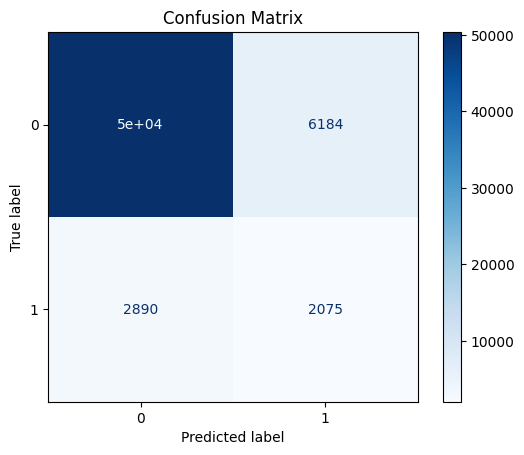

In [32]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

**Test data interpretation**

True Negatives (TN) = 50354: The model correctly predicted the negative
class (0). <br>
False Positives (FP) = 6184: The model incorrectly predicted the positive
class (1) when it was actually negative.<br>
False Negatives (FN) = 2890: The model incorrectly predicted the negative
class (0) when it was actually positive.<br>
True Positives (TP) = 2075: The model correctly predicted the positive class
 (1).<br>
 <br>
 The model has correctly predicted more of the majority class (0). Knowing
 that F1 score is only 0.3138, suggests that our model is affected by the
 imbalance data and struggles to classify the minority class (1).


## 8.2. Model Interpretation

In [35]:
results_file = os.path.join("..", "results", "final_results.pkl")
with open(results_file, "rb") as f:
    results = pkl.load(f)

clf_xgb = results['Model']

Feature Importances - weights

In [36]:
X_train_processed = pd.DataFrame(preprocessor_encode.fit_transform(X_train),
                                 columns=preprocessor_encode.get_feature_names_out())
X_test_processed = pd.DataFrame(preprocessor_encode.transform(X_test), columns=preprocessor_encode.get_feature_names_out())

fc = FeatureCreation2()
X_train_processed = fc.fit_transform(X_train_processed)
X_test_processed = fc.transform(X_test_processed)

feature_names = X_train_processed.columns
feature_importances = pd.Series(clf_xgb.feature_importances_, index=feature_names)

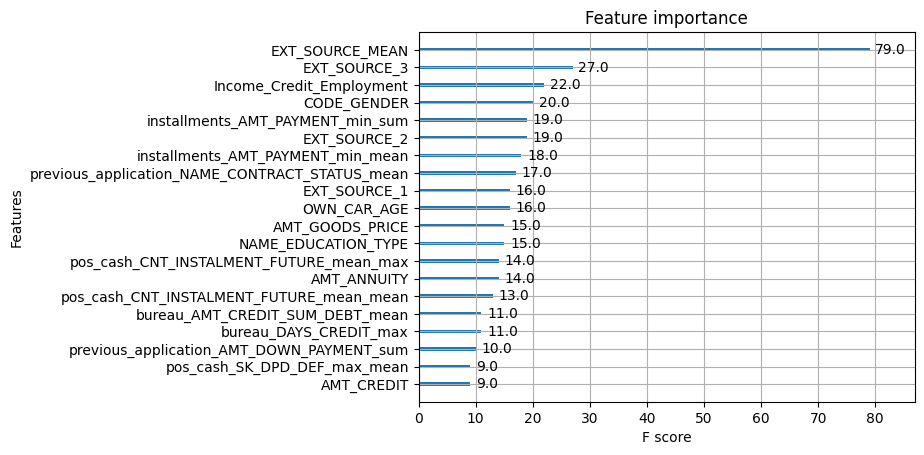

In [40]:
plot_importance(clf_xgb, importance_type='weight', max_num_features=20)
plt.show()

SHAP value - showing contribution of features

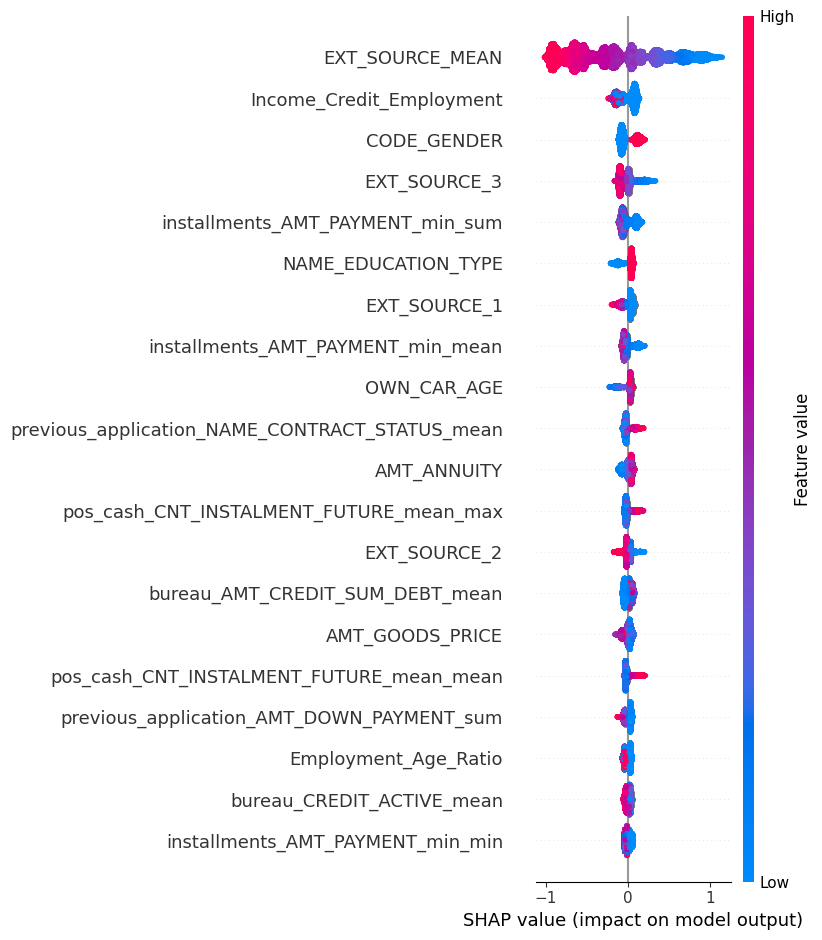

In [41]:
explainer = shap.TreeExplainer(clf_xgb)
shap_values = explainer.shap_values(X_test_processed)
shap.summary_plot(shap_values, X_test_processed)

As shown in the plot, even within top 20 features on model output, the lower
 features are starting to less distinguishable directions. To improve the
 model's classifying ability, creating more new features that can better
 separate classes, and consider removing features to reduce noise.

**What predicts default?**
1. Average of a score from external data source is the best predictor, the
higher the score, the less is the probability of defaulting.
2. Income_Credit_Employment is the second predictor. This feature was added
during feature engineering, it calculates income to credit ratios.
3. It is interesting to see how clearly gender impacts loan default.

## 8.3. Deployment

ReTrain on the whole dataset for deployment

In [42]:
X_combined = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

# Combine target labels
y_combined = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

print(f"Shape of combined features: {X_combined.shape}")
print(f"Shape of combined target: {y_combined.shape}")

Shape of combined features: (307511, 1250)
Shape of combined target: (307511,)


ReTrain

In [ ]:
X_combined_processed = pd.DataFrame(preprocessor_encode.fit_transform(X_combined),
                                    columns=preprocessor_encode.get_feature_names_out())

fc = FeatureCreation2()
X_combined_processed = fc.fit_transform(X_combined_processed)

xgb_params = studies['XGB'].best_params if 'XGB' in studies and studies['XGB'] else {}
xgb_params.update({
    'objective': 'binary:logistic',
    'random_state': 42,
    'scale_pos_weight': (y_combined == 0).sum() / (y_combined == 1).sum()
})

clf_xgb = xgb.XGBClassifier(**xgb_params)
clf_xgb.fit(X_combined_processed, y_combined)

print("Model retrained on the entire dataset (train + test).")

Save model for deployment

In [46]:
results_folder = os.path.join("..", "results")
os.makedirs(results_folder, exist_ok=True)
results_file = os.path.join(results_folder, "deploy_model.pkl")

if os.path.exists(results_file):
    print(f"Model already in {results_file}")
else:
    results = clf_xgb
    with open(results_file, "wb") as f:
        pkl.dump(results, f)
    print(f"Model saved to {results_file}")

Model saved to ../results/deploy_model.pkl


# Improvements

1. Ensemble models are providing very similar results to single models,
possibly both LGB and XGBoost have similar predictions. Adding a Logistic
Regression (simpler patterns) or kNN (local patterns) can help diversify
predictions.
2. Try other methods to fight data imbalance, like undersampling majority
class (0).